In [7]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt

In [8]:
# Download latest Covid 19 data
df = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/full_data.csv")
# Downloaded population from World Bank
# http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv
pop = pd.read_csv("population.csv", skiprows=4)
pop = pop.set_index('Country Name')

In [19]:
# Default values
values_def = 'new_cases'
since_def = '2020-03-01'
countries_def=['Italy','Spain','United Kingdom','Ireland','China','United States','Japan','South Korea','Iran','Singapore']
#countries_def=['China']

# Set the default size for the figures
plt.rcParams["figure.figsize"] = (14, 10)

In [20]:
# @global df - data frame containing Covid 19 data by date and by country
# @global pop - data frome containing population data
# @param values - one of 'new cases', 'total cases', 'new deaths', total deaths'
# @param since - show data only for dates since this date; format 'yyyy-mm-dd'
# @param countries - show data only for the specified countries
# @param by_pop - set to 1 to divide numbers by population per country, in millions
def covid(values=values_def, since=since_def, countries=countries_def, by_pop=0):
    # filter by date
    df2 = df[df.date > since]
    # generate a pivot chart
    piv = df2.pivot(index='date', columns='location', values=values)
    # filter by country
    sub = piv[countries]
    # setup title of plot
    title=values + " since " + since
    if (by_pop == 1):
        # divide each number by the population, in millions
        pop2 = pop.loc[countries, ['2018']]
        pop2 = pop2/1e6
        pop2 = pop2.transpose()
        sub = sub/pop2.iloc[0]
        title = title + " per million of population"
    # define lines for doubling every N days
    return sub, title

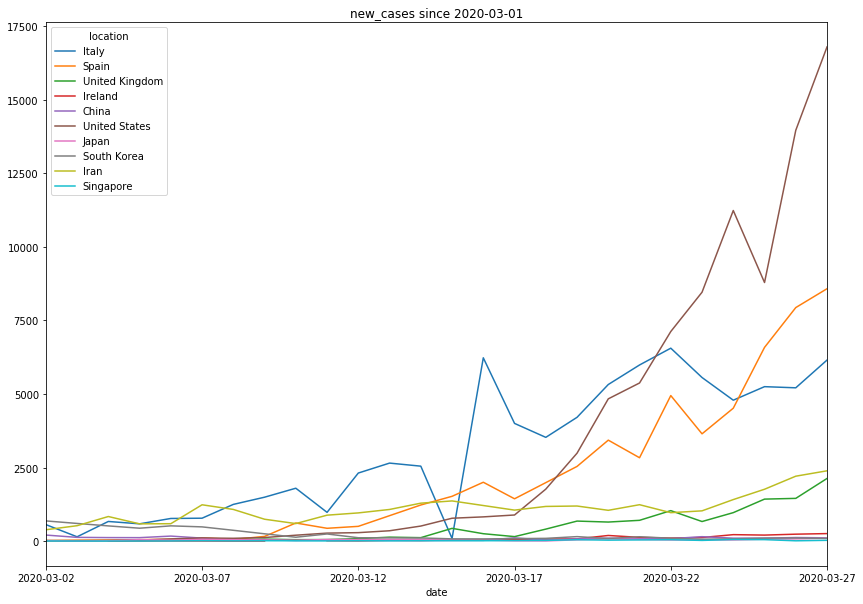

In [25]:
# use all defaults from above
sub, title = covid()
sub.plot(title=title,logy=False)

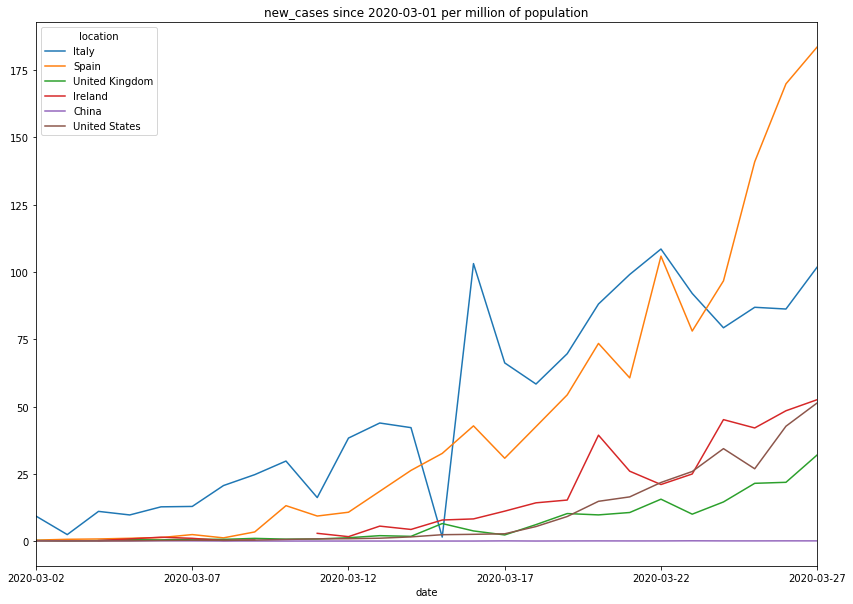

In [18]:
sub, title = covid(by_pop=1)
sub.plot(title=title,logy=False)